In [ ]:
import os
import time
import torch
import random
import scipy.io
from PIL import Image
import torch.nn as nn
import seaborn as sns
from tqdm import tqdm
import torch.optim as optim
from torchvision import models
from torchvision import datasets
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Files in folder: ['4', '7', '11', '14', '15', '22', '30', '19', '29', '28', '27', '26', '33', '39', '35', '38', '36', '37', '32', '34', '40', '31', '45', '46', '51', '48', '55', '50', '43', '49', '53', '54', '57', '58', '59', '60', '61', '62', '63', '64', '67', '68', '69', '70', '72', '74', '73', '71', '75', '80', '76', '78', '77', '90', '87', '81', '89', '85', '84', '88', '83', '82', '95', '92', '91', '97', '98', '94', '100', '101', '102', '103', '104', '105', '108', '109', '106', '112', '119', '111', '118', '117', '114', '116', '113', '115', '120', '121', '122', '123', '124', '126', '127', '128', '129', '132', '131', '133', '130', '134', '137', '138', '139', '140', '141', '142', '143', '145', '146', '148', '149', '150', '151', '153', '152', '154', '155', '157', '158', '159', '160', '162', '163']


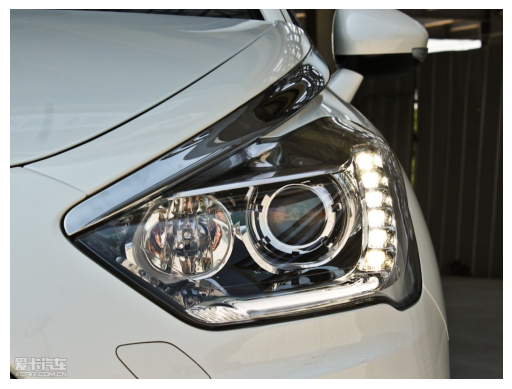

In [ ]:
folder_path = '/content/drive/MyDrive/nndl_cars_project/data/data/part'
files = os.listdir(folder_path)
print("Files in folder:", files)

image_file_path = os.path.join(folder_path, '4/509/2012/1/40928a364ce132.jpg')
image = Image.open(image_file_path)

plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
# Function to read label files
def read_label_file(label_file_path):
    with open(label_file_path, 'r') as f:
        lines = f.read().strip().split('\n')
    return lines

# paths to training and testing text files
train_text_files = {
    'part1': '/content/drive/MyDrive/nndl_cars_project/data/data/train_test_split/part/train_part_1.txt',
    'part2': '/content/drive/MyDrive/nndl_cars_project/data/data/train_test_split/part/train_part_2.txt',
    'part3': '/content/drive/MyDrive/nndl_cars_project/data/data/train_test_split/part/train_part_3.txt',
    'part4': '/content/drive/MyDrive/nndl_cars_project/data/data/train_test_split/part/train_part_4.txt',
    'part5': '/content/drive/MyDrive/nndl_cars_project/data/data/train_test_split/part/train_part_5.txt',
    'part6': '/content/drive/MyDrive/nndl_cars_project/data/data/train_test_split/part/train_part_6.txt',
    'part7': '/content/drive/MyDrive/nndl_cars_project/data/data/train_test_split/part/train_part_7.txt',
    'part8': '/content/drive/MyDrive/nndl_cars_project/data/data/train_test_split/part/train_part_8.txt',

}

test_text_files = {
    'part1': '/content/drive/MyDrive/nndl_cars_project/data/data/train_test_split/part/test_part_1.txt',
    'part2': '/content/drive/MyDrive/nndl_cars_project/data/data/train_test_split/part/test_part_2.txt',
    'part3': '/content/drive/MyDrive/nndl_cars_project/data/data/train_test_split/part/test_part_3.txt',
    'part4': '/content/drive/MyDrive/nndl_cars_project/data/data/train_test_split/part/test_part_4.txt',
    'part5': '/content/drive/MyDrive/nndl_cars_project/data/data/train_test_split/part/test_part_5.txt',
    'part6': '/content/drive/MyDrive/nndl_cars_project/data/data/train_test_split/part/test_part_6.txt',
    'part7': '/content/drive/MyDrive/nndl_cars_project/data/data/train_test_split/part/test_part_7.txt',
    'part8': '/content/drive/MyDrive/nndl_cars_project/data/data/train_test_split/part/test_part_8.txt',
}

# Create dictionaries to hold image paths and labels
train_image_label_mapping = []
test_image_label_mapping = []

# Define the label mapping for parts
label_mapping = {
    'part1': 'headlight',
    'part2': 'taillight',
    'part3': 'fog light',
    'part4': 'air intake',
    'part5': 'console',
    'part6': 'steering wheel',
    'part7': 'dashboard',
    'part8': 'gear lever'
}

# Read training files
for label, path in train_text_files.items():
    images = read_label_file(path)
    for image in images:
        # Map the label to the correct part label
        if label in label_mapping:
            correct_label = label_mapping[label]
            train_image_label_mapping.append((image, correct_label))

# Read testing files
for label, path in test_text_files.items():
    images = read_label_file(path)
    for image in images:
        # Map the label to the correct part label
        if label in label_mapping:
            correct_label = label_mapping[label]
            test_image_label_mapping.append((image, correct_label))

# Create a mapping from part names to indices
part_names = sorted(set(label for _, label in train_image_label_mapping + test_image_label_mapping))
label_to_index = {name: index for index, name in enumerate(part_names)}

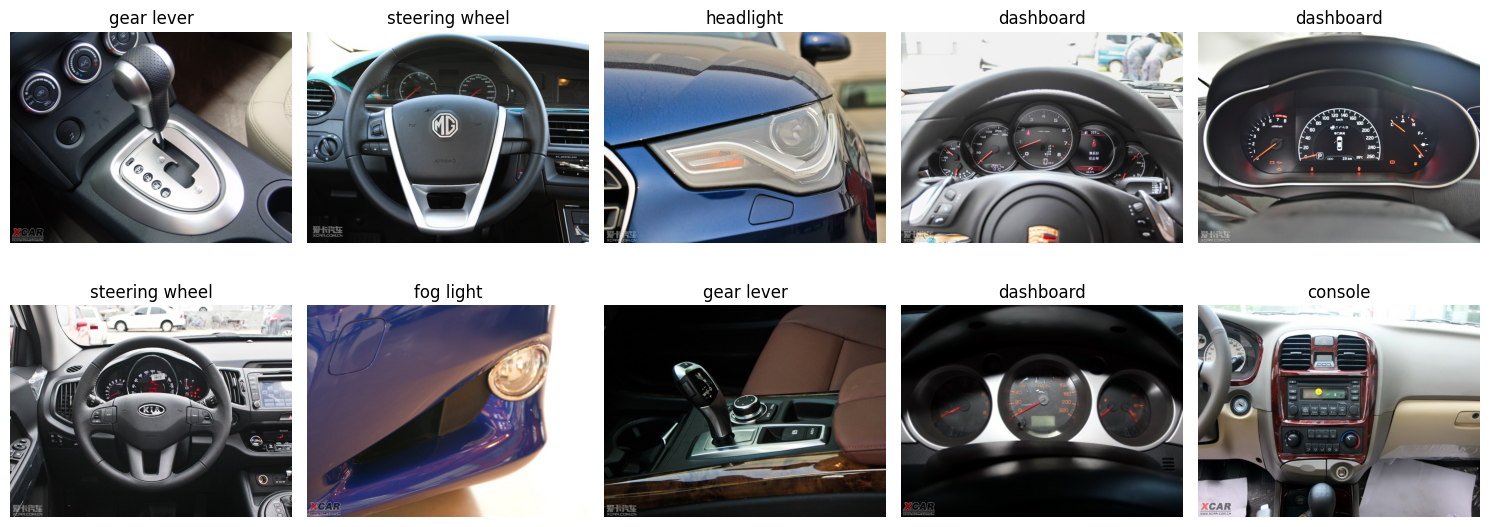

In [ ]:
# Function to visualize images with their labels
def visualize_images_with_labels(image_label_mapping, root_dir, num_images=10):
    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        idx = random.randint(0, len(image_label_mapping) - 1)
        relative_path, label = image_label_mapping[idx]
        image_path = os.path.join(root_dir, relative_path)  # Construct full image path

        try:
            # Load and display the image
            img = Image.open(image_path)
            plt.imshow(img)
            plt.title(label)
            plt.axis('off')
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")

    plt.tight_layout()
    plt.show()

# Define the root directory for images
image_root_dir = '/content/drive/MyDrive/nndl_cars_project/data/data/part'

# Visualize 10 random images with labels from the train dataset
visualize_images_with_labels(train_image_label_mapping, image_root_dir, num_images=10)


In [ ]:
# Create a Custom Dataset class
class CarDataset(Dataset):
    def __init__(self, mapping, label_to_index, base_dir, transform=None):
        self.mapping = mapping
        self.label_to_index = label_to_index
        self.base_dir = base_dir
        self.transform = transform
        self.classes = list(self.label_to_index.values())

    def __len__(self):
        return len(self.mapping)

    def __getitem__(self, idx):
        img_path, label = self.mapping[idx]
        img_path = os.path.join(self.base_dir, img_path)
        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            print(f"File not found: {img_path}")
            return None, None

        if self.transform:
            image = self.transform(image)

        label_index = self.label_to_index.get(label, -1)  # Handle missing labels

        return image, label_index


# Define transformations
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # the preferred image size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# the base directory where the images are stored
base_dir = '/content/drive/MyDrive/nndl_cars_project/data/data/part'


In [ ]:
# Function to select a subset of the dataset
def select_subset(image_label_mapping, num_samples):
    return random.sample(image_label_mapping, num_samples)

# Subsets for training and testing
num_samples = 4000  # Number of samples to use for training
num_samples_test = 1000 # Number of samples to use for test
train_subset = select_subset(train_image_label_mapping, num_samples)
test_subset = select_subset(test_image_label_mapping, num_samples_test)

# Split train_subset into train and validation subsets
val_ratio = 0.2  # 20% of the training subset will be used for validation
train_subset_split, val_subset = train_test_split(train_subset, test_size=val_ratio, random_state=42)

# Update the DataLoader and Dataset to use the subsets
train_subset_dataset = CarDataset(train_subset_split, label_to_index, base_dir, transform=transform)
val_subset_dataset = CarDataset(val_subset, label_to_index, base_dir, transform=transform)
test_subset_dataset = CarDataset(test_subset, label_to_index, base_dir, transform=transform)

train_loader = DataLoader(train_subset_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_subset_dataset, batch_size=32, shuffle=False, num_workers=2)

# Print sizes of each subset
print(f"Subset sizes - Train: {len(train_subset_dataset)}, Validation: {len(val_subset_dataset)}, Test: {len(test_subset_dataset)}")


Subset sizes - Train: 3200, Validation: 800, Test: 1000


In [ ]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Training ResNet18...
Epoch 1/10, Train Loss: 0.9424, Val Loss: 0.6608, Train Acc: 0.6769, Val Acc: 0.7987, Test Loss: 0.7049, Test Acc: 0.7510
Epoch 2/10, Train Loss: 0.4084, Val Loss: 1.3000, Train Acc: 0.8706, Val Acc: 0.6338, Test Loss: 1.3755, Test Acc: 0.6210
Epoch 3/10, Train Loss: 0.2952, Val Loss: 0.2649, Train Acc: 0.9075, Val Acc: 0.9250, Test Loss: 0.3346, Test Acc: 0.8990
Epoch 4/10, Train Loss: 0.2574, Val Loss: 0.3737, Train Acc: 0.9144, Val Acc: 0.8875, Test Loss: 0.4369, Test Acc: 0.8600
Epoch 5/10, Train Loss: 0.2017, Val Loss: 0.2290, Train Acc: 0.9350, Val Acc: 0.9313, Test Loss: 0.2599, Test Acc: 0.9310
Epoch 6/10, Train Loss: 0.1502, Val Loss: 0.1995, Train Acc: 0.9534, Val Acc: 0.9400, Test Loss: 0.2297, Test Acc: 0.9300
Epoch 7/10, Train Loss: 0.1398, Val Loss: 0.2331, Train Acc: 0.9556, Val Acc: 0.9287, Test Loss: 0.2728, Test Acc: 0.9150
Epoch 8/10, Train Loss: 0.1145, Val Loss: 0.2373, Train Acc: 0.9613, Val Acc: 0.9213, Test Loss: 0.3642, Test Acc: 0.8920
Epo

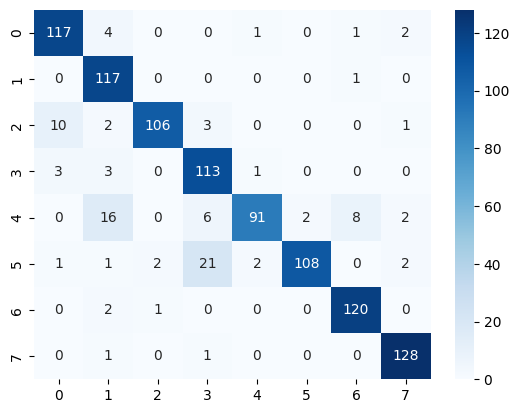

In [ ]:
# Custom ResNet18 implementation

class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet, self).__init__()
        self.base_model = models.resnet18(weights=None)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Training function
def train_model(model, criterion, optimizer, train_loader, val_loader, test_loader, num_epochs):
    model.to(device)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'test_loss': [], 'test_acc': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Validation phase
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct / total
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Test phase
        test_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        test_loss = test_loss / len(test_loader.dataset)
        test_acc = correct / total
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    return history

# Train ResNet18
num_classes = 8
resnet_model = CustomResNet(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)

print("Training ResNet18...")
resnet_history = train_model(resnet_model, criterion, optimizer, train_loader, val_loader, test_loader, num_epochs=10)

# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.show()

print("Evaluating ResNet18...")
evaluate_model(resnet_model, test_loader)

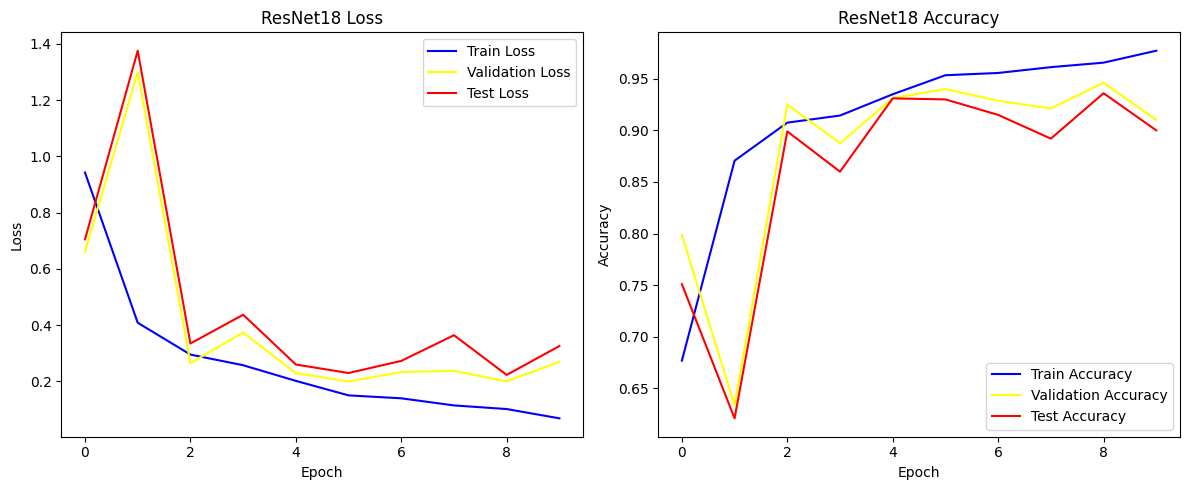

In [ ]:
# Plotting ResNet results
def plot_resnet_history(history):
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss', color='blue')
    plt.plot(history['val_loss'], label='Validation Loss', color='yellow')
    plt.plot(history['test_loss'], label='Test Loss', color='red')
    plt.title("ResNet18 Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy', color='blue')
    plt.plot(history['val_acc'], label='Validation Accuracy', color='yellow')
    plt.plot(history['test_acc'], label='Test Accuracy', color='red')
    plt.title("ResNet18 Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_resnet_history(resnet_history)

In [ ]:
# Saving the model
torch.save({
    'model_state_dict': resnet_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': resnet_history
}, 'resnet_checkpoint.pth')

Training with AdamW...


<ipython-input-12-d4e22d666675>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("resnet_checkpoint.pth")


Epoch 1/10, Train Loss: 0.1451, Val Loss: 0.1907, Train Acc: 0.9559, Val Acc: 0.9450, Test Loss: 0.2358, Test Acc: 0.9320
Epoch 2/10, Train Loss: 0.0862, Val Loss: 1.1988, Train Acc: 0.9725, Val Acc: 0.7113, Test Loss: 1.0951, Test Acc: 0.7250
Epoch 3/10, Train Loss: 0.1061, Val Loss: 0.1931, Train Acc: 0.9650, Val Acc: 0.9387, Test Loss: 0.2089, Test Acc: 0.9490
Epoch 4/10, Train Loss: 0.0678, Val Loss: 0.6200, Train Acc: 0.9769, Val Acc: 0.8325, Test Loss: 0.5947, Test Acc: 0.8430
Epoch 5/10, Train Loss: 0.0609, Val Loss: 0.1712, Train Acc: 0.9806, Val Acc: 0.9525, Test Loss: 0.1955, Test Acc: 0.9440
Epoch 6/10, Train Loss: 0.0380, Val Loss: 0.2892, Train Acc: 0.9881, Val Acc: 0.9300, Test Loss: 0.3182, Test Acc: 0.9280
Epoch 7/10, Train Loss: 0.0709, Val Loss: 0.1280, Train Acc: 0.9766, Val Acc: 0.9613, Test Loss: 0.1438, Test Acc: 0.9640
Epoch 8/10, Train Loss: 0.0390, Val Loss: 0.2031, Train Acc: 0.9872, Val Acc: 0.9437, Test Loss: 0.2152, Test Acc: 0.9460
Epoch 9/10, Train Loss: 

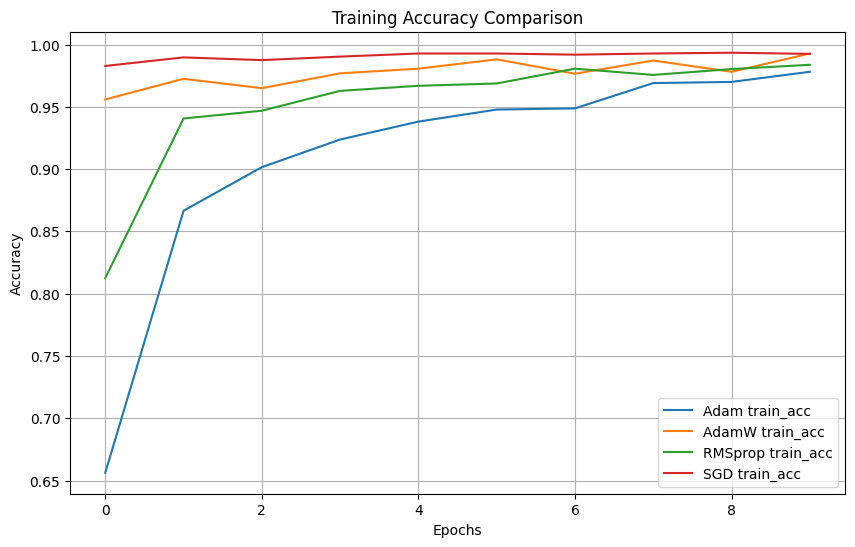

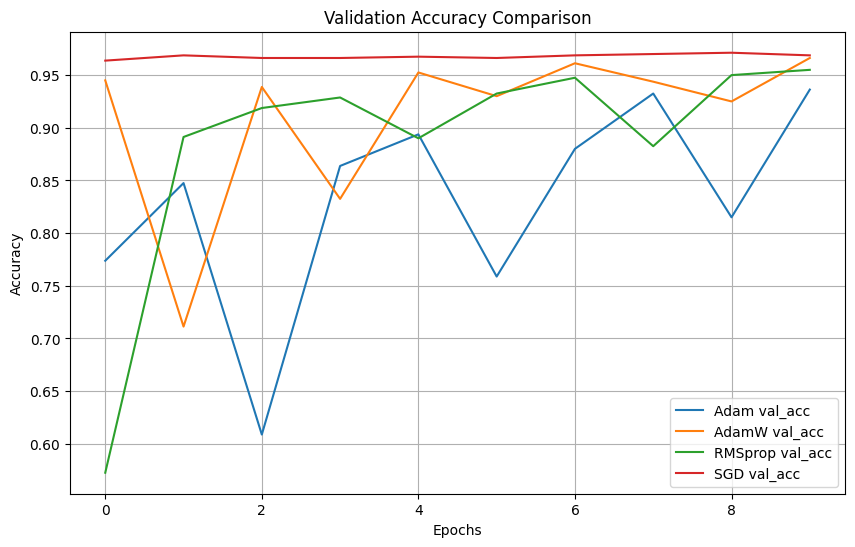

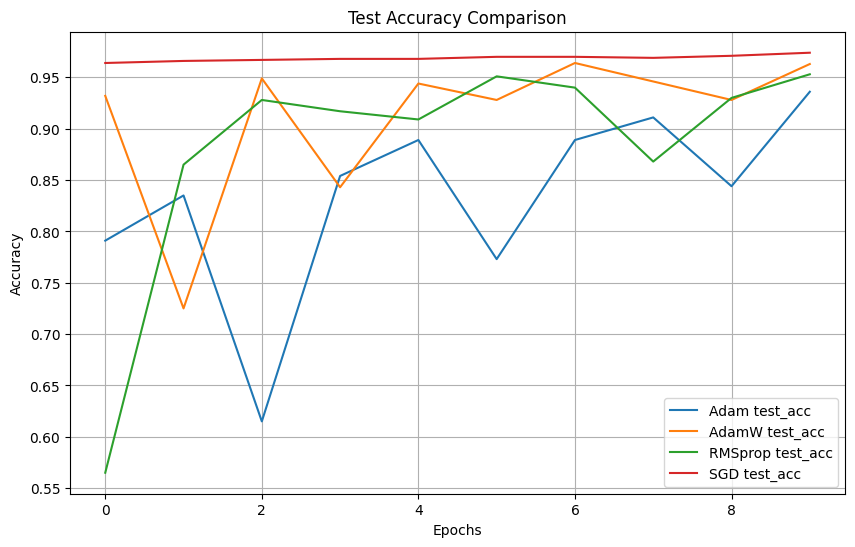

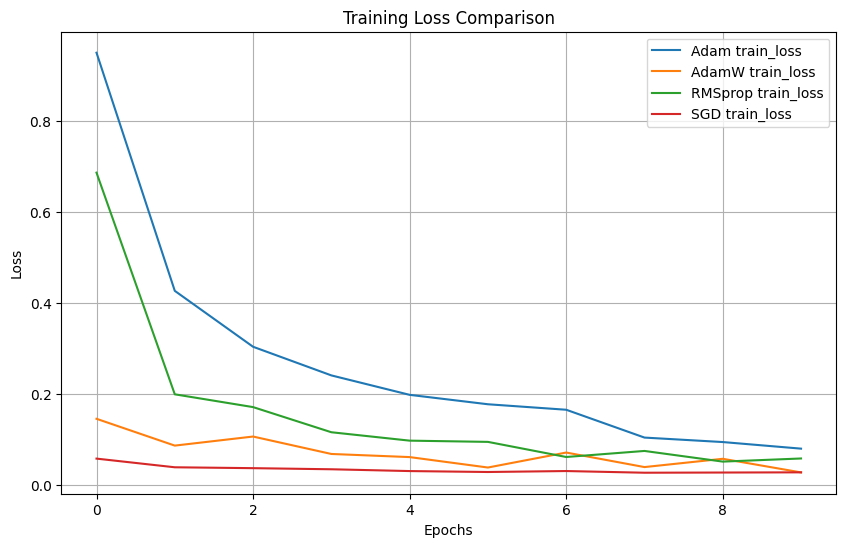

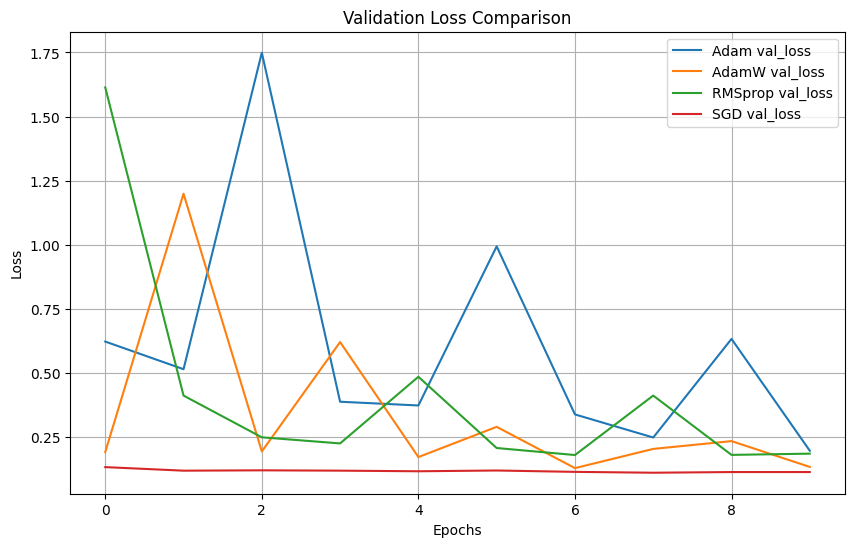

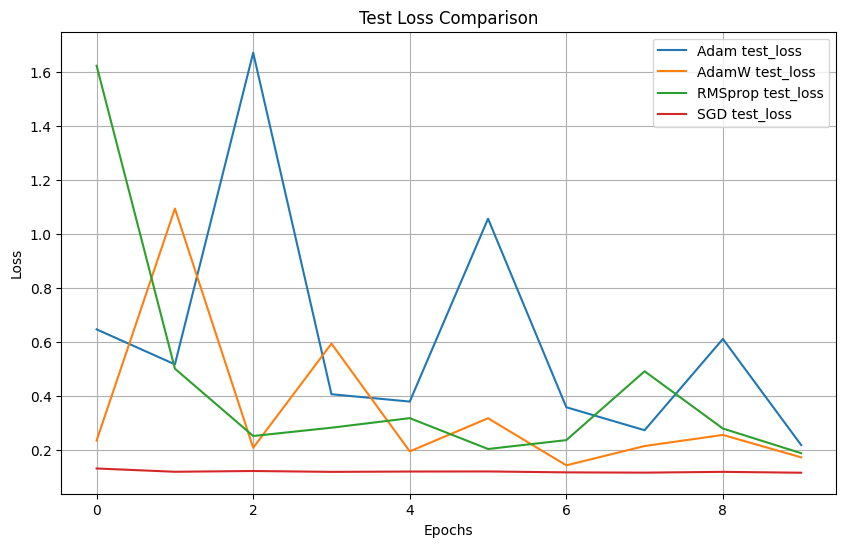

In [ ]:
# Comparison of different optimizers with ResNet18

# Save Adam history after initial training
adam_history_resnet = resnet_history

# Train with other optimizers
other_optimizers = {
    'AdamW': lambda: optim.AdamW(resnet_model.parameters(), lr=0.001),
    'RMSprop': lambda: optim.RMSprop(resnet_model.parameters(), lr=0.001),
    'SGD': lambda: optim.SGD(resnet_model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
}

def train_with_optimizer(optimizer_name, optimizer_func):
    print(f"Training with {optimizer_name}...")

    # Load the checkpoint from the Adam-trained model
    checkpoint = torch.load("resnet_checkpoint.pth")
    resnet_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer = optimizer_func()

    # Train the model and store metrics
    history = train_model(resnet_model, criterion, optimizer, train_loader, val_loader, test_loader, num_epochs=10)
    return history

# Train with all optimizers and save histories
other_histories = {}
for optimizer_name, optimizer_func in other_optimizers.items():
    other_histories[optimizer_name] = train_with_optimizer(optimizer_name, optimizer_func)

all_histories = {'Adam': adam_history_resnet}
all_histories.update(other_histories)

# Plotting function
def plot_comparison(histories, metric_name, ylabel, title):
    plt.figure(figsize=(10, 6))
    for opt_name, history in histories.items():
        plt.plot(history[metric_name], label=f"{opt_name} {metric_name}")
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

# Plot results
plot_comparison(all_histories, 'train_acc', 'Accuracy', 'Training Accuracy Comparison')
plot_comparison(all_histories, 'val_acc', 'Accuracy', 'Validation Accuracy Comparison')
plot_comparison(all_histories, 'test_acc', 'Accuracy', 'Test Accuracy Comparison')
plot_comparison(all_histories, 'train_loss', 'Loss', 'Training Loss Comparison')
plot_comparison(all_histories, 'val_loss', 'Loss', 'Validation Loss Comparison')
plot_comparison(all_histories, 'test_loss', 'Loss', 'Test Loss Comparison')


Training with CrossEntropyLoss...
Training with FocalLoss...


<ipython-input-17-f391fac49e0d>:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("resnet_checkpoint.pth")


Epoch 1/10, Train Loss: 0.0636, Val Loss: 0.0505, Train Acc: 0.9409, Val Acc: 0.9500, Test Loss: 0.0867, Test Acc: 0.9390
Epoch 2/10, Train Loss: 0.0420, Val Loss: 0.1395, Train Acc: 0.9594, Val Acc: 0.9025, Test Loss: 0.1611, Test Acc: 0.8840
Epoch 3/10, Train Loss: 0.0416, Val Loss: 0.0577, Train Acc: 0.9563, Val Acc: 0.9487, Test Loss: 0.0879, Test Acc: 0.9390
Epoch 4/10, Train Loss: 0.0206, Val Loss: 0.0657, Train Acc: 0.9769, Val Acc: 0.9500, Test Loss: 0.0917, Test Acc: 0.9340
Epoch 5/10, Train Loss: 0.0277, Val Loss: 0.0956, Train Acc: 0.9706, Val Acc: 0.9375, Test Loss: 0.1053, Test Acc: 0.9440
Epoch 6/10, Train Loss: 0.0128, Val Loss: 0.0372, Train Acc: 0.9844, Val Acc: 0.9725, Test Loss: 0.0552, Test Acc: 0.9680
Epoch 7/10, Train Loss: 0.0060, Val Loss: 0.0650, Train Acc: 0.9912, Val Acc: 0.9575, Test Loss: 0.0855, Test Acc: 0.9530
Epoch 8/10, Train Loss: 0.0141, Val Loss: 0.0750, Train Acc: 0.9822, Val Acc: 0.9287, Test Loss: 0.1096, Test Acc: 0.9260
Epoch 9/10, Train Loss: 

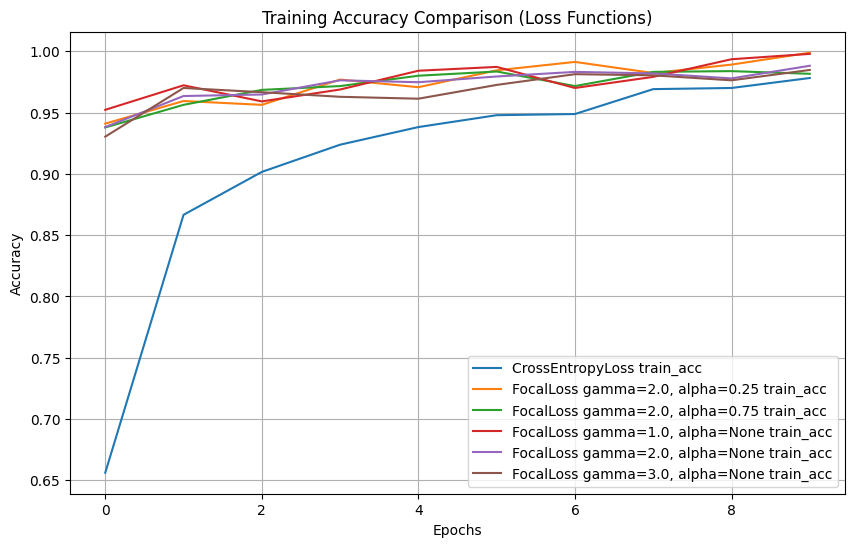

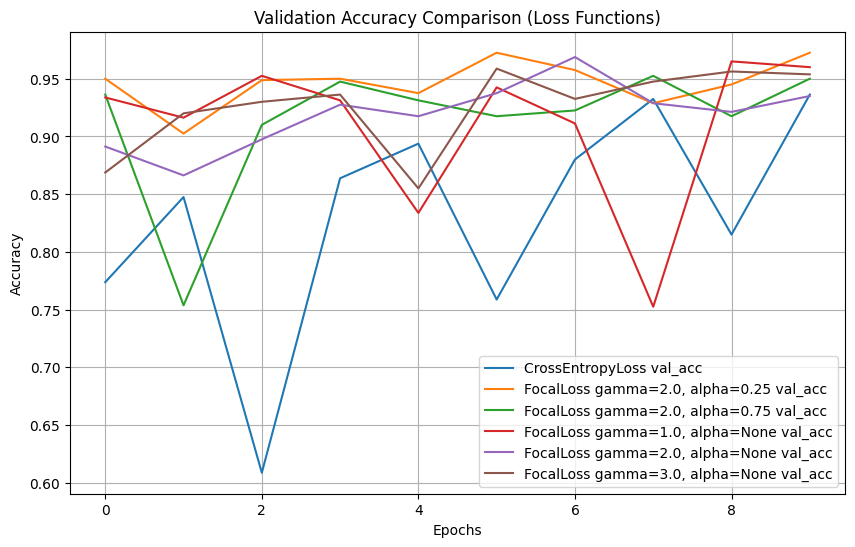

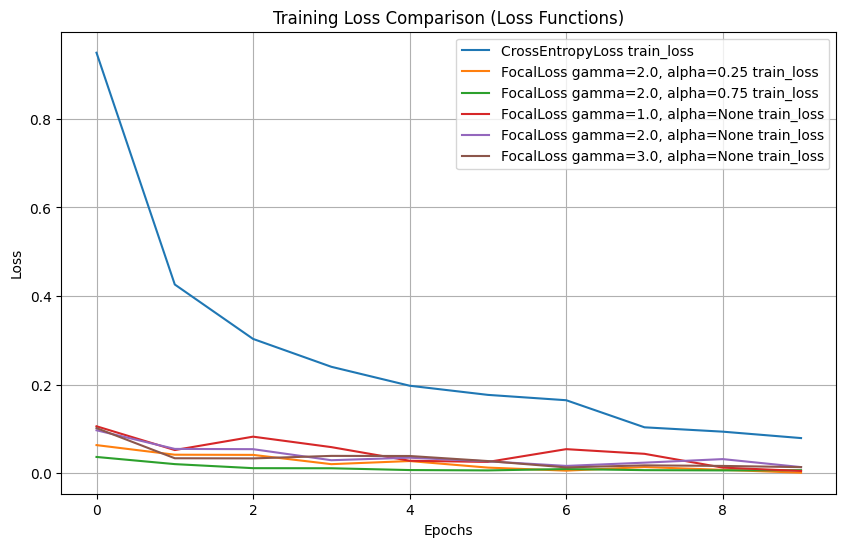

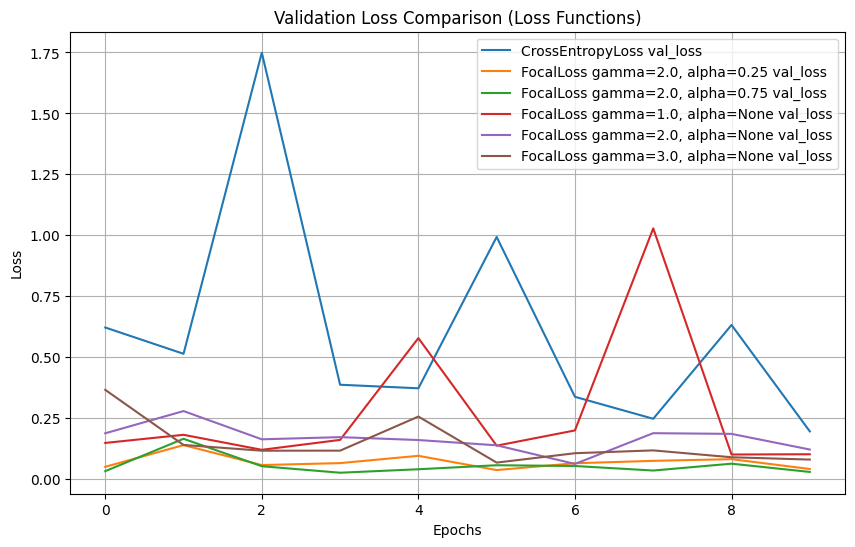

In [ ]:
# Fine-Tuning with focal loss with ResNet18

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, num_classes=8):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.num_classes = num_classes

    def forward(self, inputs, targets):
        # Apply softmax to the inputs to get probabilities
        probs = F.softmax(inputs, dim=1)

        # Convert targets to one-hot encoding
        targets = F.one_hot(targets, num_classes=self.num_classes).float()

        # Get the probabilities for the true class labels
        true_probs = torch.sum(probs * targets, dim=1)

        # Compute the Focal Loss
        focal_weight = (1 - true_probs) ** self.gamma

        # Reshape focal_weight to be compatible with targets
        focal_weight = focal_weight.view(-1, 1)

        if self.alpha is not None:
            # Alpha weighting for class imbalance
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            loss = -alpha_t * focal_weight * torch.log(true_probs).view(-1, 1)
        else:
            loss = -focal_weight * torch.log(true_probs).view(-1, 1)

        return loss.mean()


def train_with_loss_function(loss_fn, optimizer_class, optimizer_args, num_epochs, is_cross_entropy=False):
    print(f"Training with {loss_fn.__class__.__name__}...")

    if is_cross_entropy:
        return resnet_history  # Using the pre-obtained loss and accuracy from CrossEntropyLoss training

    # Load checkpoint for other losses
    checkpoint = torch.load("resnet_checkpoint.pth")
    resnet_model.load_state_dict(checkpoint['model_state_dict'])  # Load checkpoint

    optimizer = optimizer_class(resnet_model.parameters(), **optimizer_args)

    # Train the model and get history
    history = train_model(resnet_model, loss_fn, optimizer, train_loader, val_loader, test_loader, num_epochs)
    return history

# Focal Loss parameters
loss_fn_configs = [
    {"loss_fn": nn.CrossEntropyLoss(), "label": "CrossEntropyLoss", "is_cross_entropy": True},  # CrossEntropyLoss configuration
    {"loss_fn": FocalLoss(gamma=2.0, alpha=0.25), "label": "FocalLoss gamma=2.0, alpha=0.25", "is_cross_entropy": False},
    {"loss_fn": FocalLoss(gamma=2.0, alpha=0.75), "label": "FocalLoss gamma=2.0, alpha=0.75", "is_cross_entropy": False},
    {"loss_fn": FocalLoss(gamma=1.0, alpha=None), "label": "FocalLoss gamma=1.0, alpha=None", "is_cross_entropy": False},
    {"loss_fn": FocalLoss(gamma=2.0, alpha=None), "label": "FocalLoss gamma=2.0, alpha=None", "is_cross_entropy": False},
    {"loss_fn": FocalLoss(gamma=3.0, alpha=None), "label": "FocalLoss gamma=3.0, alpha=None", "is_cross_entropy": False}
]

# Optimizer setup
optimizer_class = optim.Adam
optimizer_args = {"lr": 0.001}

# Train with different loss functions
loss_histories = {}
for config in loss_fn_configs:
    loss_histories[config['label']] = train_with_loss_function(
        loss_fn=config["loss_fn"],
        optimizer_class=optimizer_class,
        optimizer_args=optimizer_args,
        num_epochs=10,
        is_cross_entropy=config['is_cross_entropy']
    )

# Plot results
plot_comparison(loss_histories, 'train_acc', 'Accuracy', 'Training Accuracy Comparison (Loss Functions)')
plot_comparison(loss_histories, 'val_acc', 'Accuracy', 'Validation Accuracy Comparison (Loss Functions)')
plot_comparison(loss_histories, 'train_loss', 'Loss', 'Training Loss Comparison (Loss Functions)')
plot_comparison(loss_histories, 'val_loss', 'Loss', 'Validation Loss Comparison (Loss Functions)')


Training InceptionV3...
Epoch 1/10 - Train Loss: 0.8379, Train Acc: 0.7194, Val Loss: 0.5517, Val Acc: 0.8337, Test Loss: 0.5040, Test Acc: 0.8470
Epoch 2/10 - Train Loss: 0.3810, Train Acc: 0.8806, Val Loss: 0.2813, Val Acc: 0.9025, Test Loss: 0.2981, Test Acc: 0.8980
Epoch 3/10 - Train Loss: 0.2488, Train Acc: 0.9278, Val Loss: 0.3644, Val Acc: 0.8838, Test Loss: 0.3947, Test Acc: 0.8790
Epoch 4/10 - Train Loss: 0.2166, Train Acc: 0.9350, Val Loss: 0.1684, Val Acc: 0.9487, Test Loss: 0.1653, Test Acc: 0.9530
Epoch 5/10 - Train Loss: 0.1595, Train Acc: 0.9503, Val Loss: 0.1933, Val Acc: 0.9450, Test Loss: 0.2009, Test Acc: 0.9390
Epoch 6/10 - Train Loss: 0.1470, Train Acc: 0.9578, Val Loss: 0.1351, Val Acc: 0.9587, Test Loss: 0.1711, Test Acc: 0.9590
Epoch 7/10 - Train Loss: 0.1240, Train Acc: 0.9609, Val Loss: 0.2923, Val Acc: 0.9263, Test Loss: 0.2193, Test Acc: 0.9340
Epoch 8/10 - Train Loss: 0.1212, Train Acc: 0.9616, Val Loss: 0.3608, Val Acc: 0.9100, Test Loss: 0.3194, Test Acc:

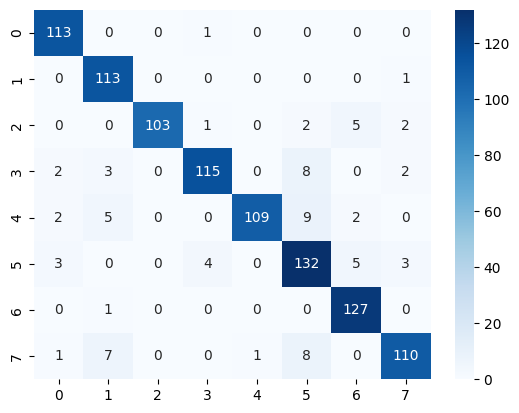

In [ ]:
# Inception V3

from torchvision.models.inception import InceptionOutputs
# Training function with test loss and test accuracy
num_classes = 8
def train_model(model, criterion, optimizer, train_loader, val_loader, test_loader, num_epochs):
    model.to(device)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'test_loss': [], 'test_acc': []}

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            # Handle InceptionOutputs
            if isinstance(outputs, InceptionOutputs):
                outputs = outputs.logits

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss /= len(train_loader.dataset)
        train_acc = correct_train / total_train
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                if isinstance(outputs, InceptionOutputs):
                    outputs = outputs.logits

                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss /= len(val_loader.dataset)
        val_acc = correct_val / total_val
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Test Phase
        test_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                if isinstance(outputs, InceptionOutputs):
                    outputs = outputs.logits

                loss = criterion(outputs, labels)
                test_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct_test += (preds == labels).sum().item()
                total_test += labels.size(0)

        test_loss /= len(test_loader.dataset)
        test_acc = correct_test / total_test
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)

        print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    return history

# Custom InceptionV3 implementation
class CustomInception(nn.Module):
    def __init__(self, num_classes):
        super(CustomInception, self).__init__()
        self.base_model = models.inception_v3(weights=None)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# train InceptionV3
inception_model = CustomInception(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(inception_model.parameters(), lr=0.001)

print("Training InceptionV3...")
inception_history = train_model(inception_model, criterion, optimizer, train_loader, val_loader, test_loader, num_epochs=10)

def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.show()

# Evaluate the model
print("Evaluating InceptionV3...")
evaluate_model(inception_model, test_loader)

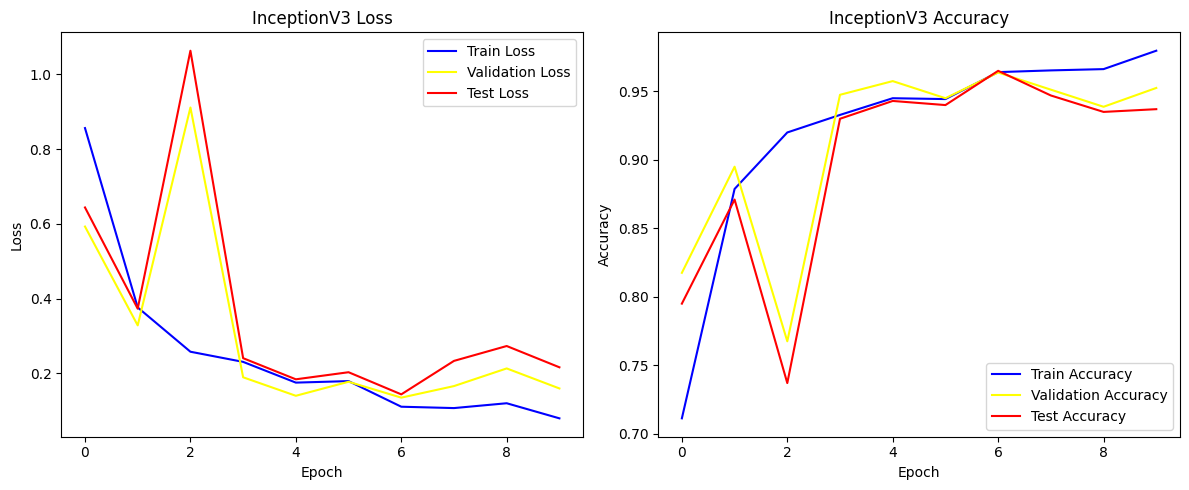

In [ ]:
# Plotting Inception results
def plot_inception_history(history):
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss', color='blue')
    plt.plot(history['val_loss'], label='Validation Loss', color='yellow')
    plt.plot(history['test_loss'], label='Test Loss', color='red')
    plt.title("InceptionV3 Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy', color='blue')
    plt.plot(history['val_acc'], label='Validation Accuracy', color='yellow')
    plt.plot(history['test_acc'], label='Test Accuracy', color='red')
    plt.title("InceptionV3 Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_inception_history(inception_history)

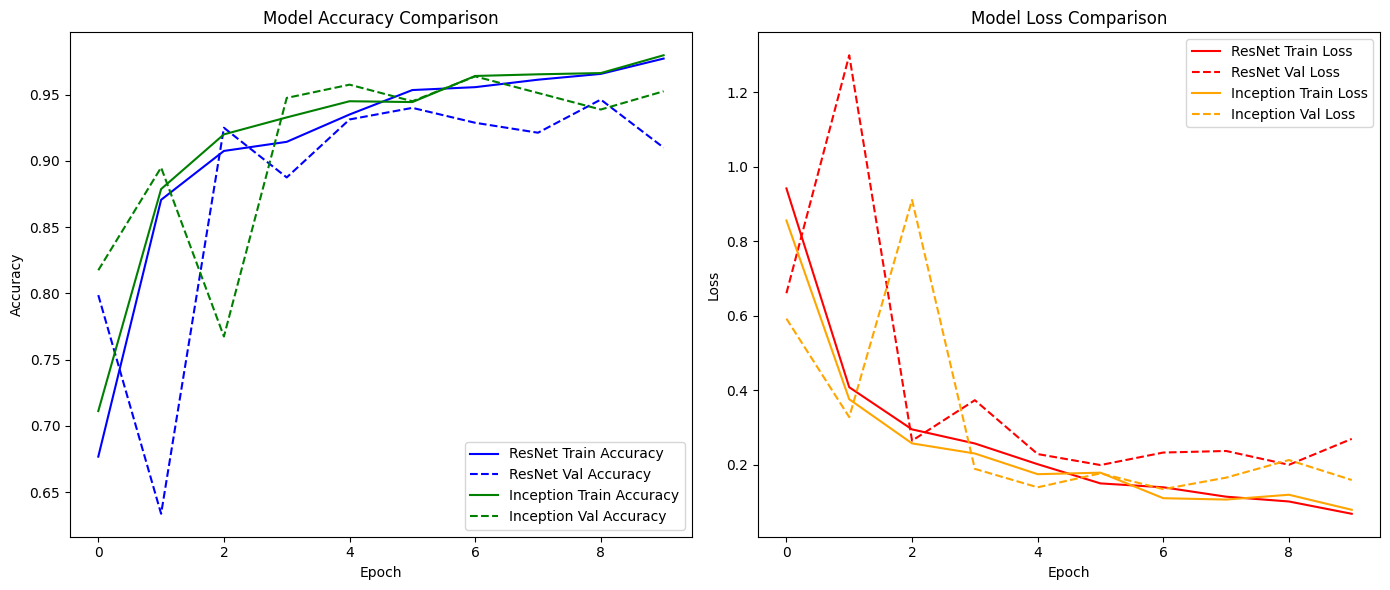

In [ ]:
# Combined Plot for Accuracies and Losses
def plot_combined_history(resnet_history, inception_history):
    plt.figure(figsize=(14, 6))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(resnet_history['train_acc'], label='ResNet Train Accuracy', color='blue', linestyle='-')
    plt.plot(resnet_history['val_acc'], label='ResNet Val Accuracy', color='blue', linestyle='--')
    plt.plot(inception_history['train_acc'], label='Inception Train Accuracy', color='green', linestyle='-')
    plt.plot(inception_history['val_acc'], label='Inception Val Accuracy', color='green', linestyle='--')
    plt.title("Model Accuracy Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(resnet_history['train_loss'], label='ResNet Train Loss', color='red', linestyle='-')
    plt.plot(resnet_history['val_loss'], label='ResNet Val Loss', color='red', linestyle='--')
    plt.plot(inception_history['train_loss'], label='Inception Train Loss', color='orange', linestyle='-')
    plt.plot(inception_history['val_loss'], label='Inception Val Loss', color='orange', linestyle='--')
    plt.title("Model Loss Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_combined_history(resnet_history, inception_history)


In [ ]:
# Saving the model
torch.save({
    'model_state_dict': inception_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': inception_history
}, 'inception_checkpoint.pth')

Training with AdamW...


<ipython-input-16-5acbcbb7f33e>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("inception_checkpoint.pth")


Epoch 1/10 - Train Loss: 0.1840, Train Acc: 0.9456, Val Loss: 0.2978, Val Acc: 0.9012, Test Loss: 0.3713, Test Acc: 0.8950
Epoch 2/10 - Train Loss: 0.1532, Train Acc: 0.9516, Val Loss: 0.2676, Val Acc: 0.9237, Test Loss: 0.3467, Test Acc: 0.9120
Epoch 3/10 - Train Loss: 0.1443, Train Acc: 0.9622, Val Loss: 0.3841, Val Acc: 0.8850, Test Loss: 0.4026, Test Acc: 0.8910
Epoch 4/10 - Train Loss: 0.1144, Train Acc: 0.9656, Val Loss: 0.1667, Val Acc: 0.9550, Test Loss: 0.1902, Test Acc: 0.9490
Epoch 5/10 - Train Loss: 0.0778, Train Acc: 0.9778, Val Loss: 0.1434, Val Acc: 0.9637, Test Loss: 0.1621, Test Acc: 0.9620
Epoch 6/10 - Train Loss: 0.1271, Train Acc: 0.9634, Val Loss: 0.1946, Val Acc: 0.9563, Test Loss: 0.1909, Test Acc: 0.9570
Epoch 7/10 - Train Loss: 0.0776, Train Acc: 0.9741, Val Loss: 0.1345, Val Acc: 0.9613, Test Loss: 0.1712, Test Acc: 0.9570
Epoch 8/10 - Train Loss: 0.0611, Train Acc: 0.9825, Val Loss: 0.1924, Val Acc: 0.9500, Test Loss: 0.2212, Test Acc: 0.9520
Epoch 9/10 - Tra

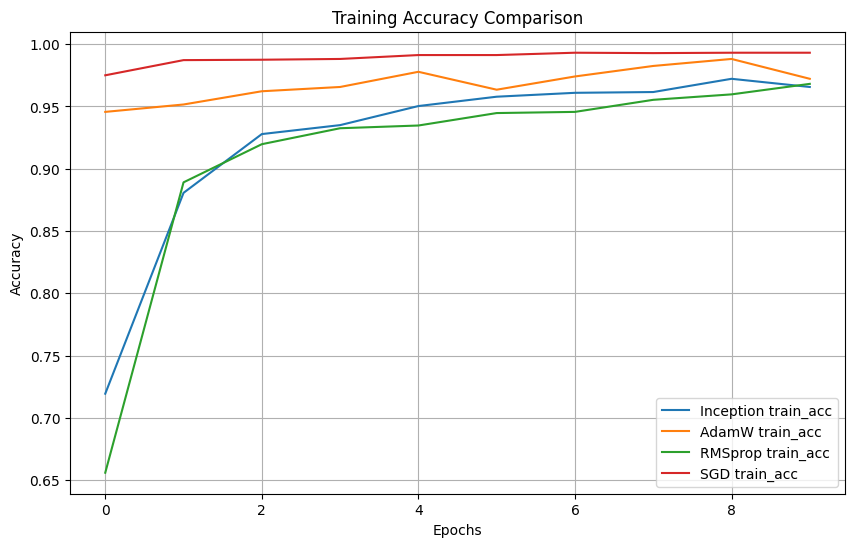

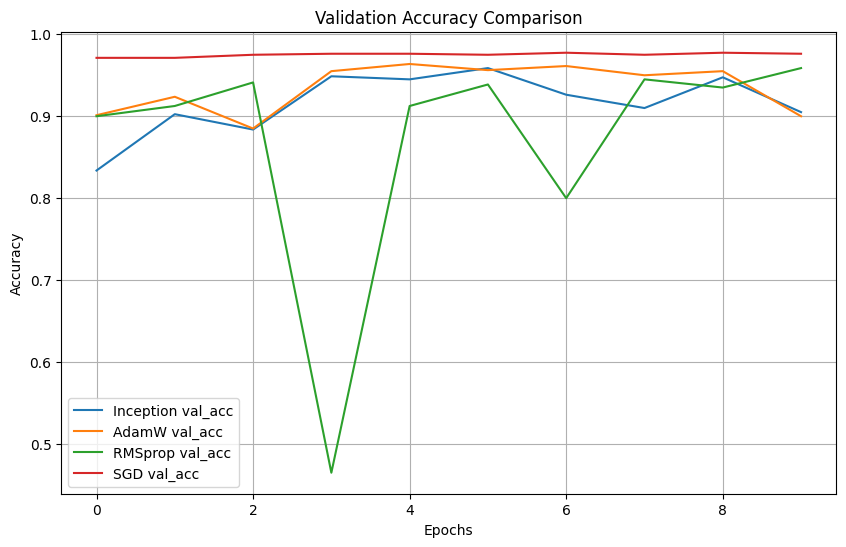

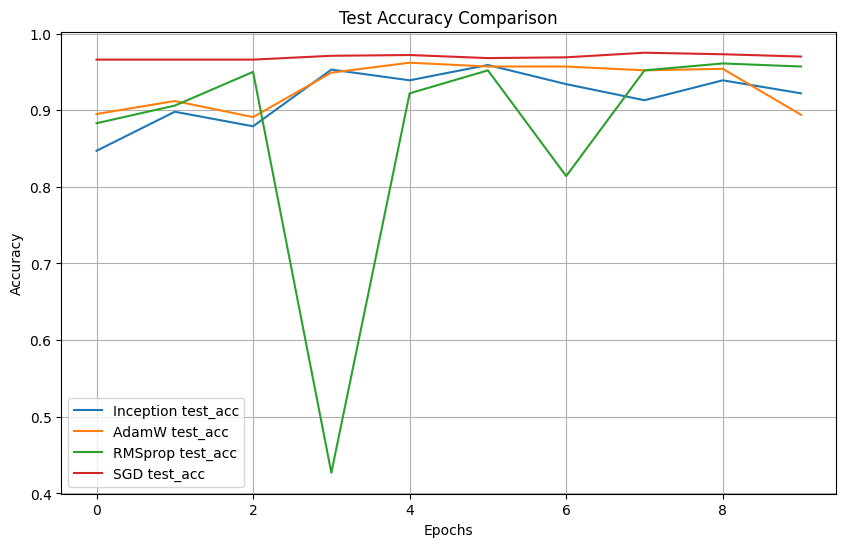

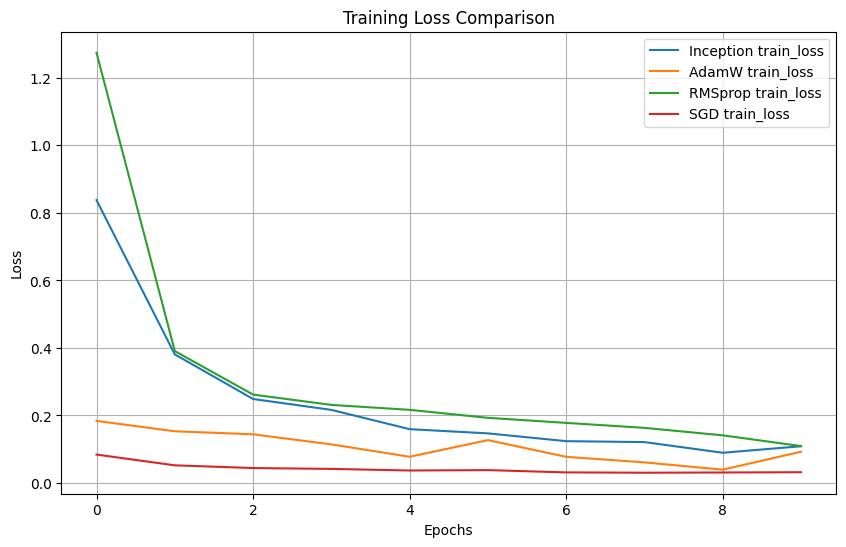

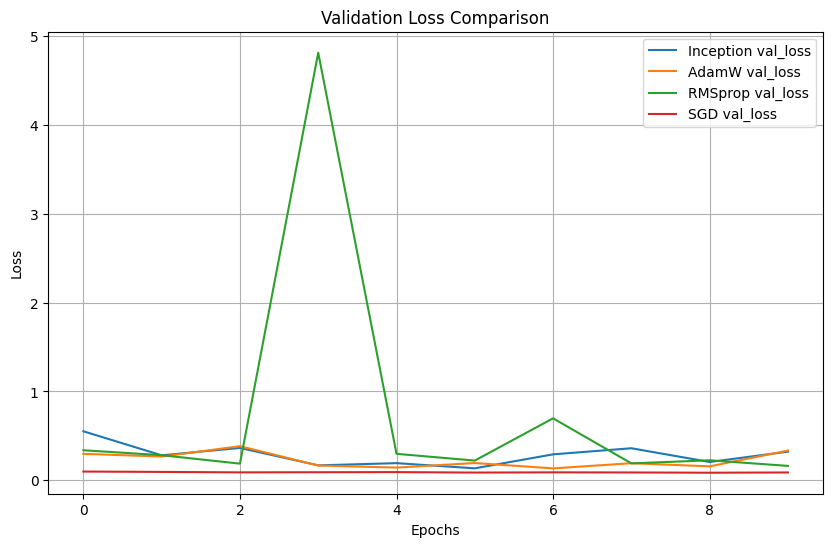

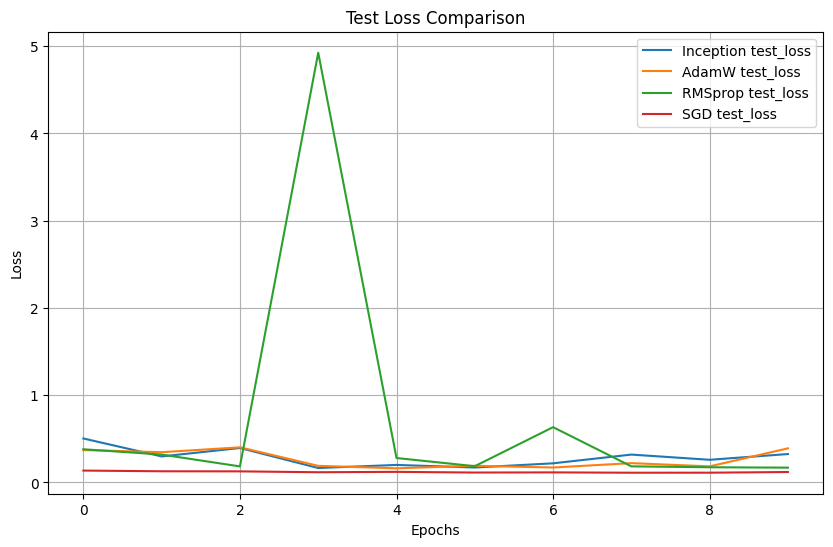

In [ ]:
# Comparison of different optimizers with Inception V3

# Save Inception history after initial training
inception_history = inception_history

# Train with other optimizers
other_optimizers = {
    'AdamW': lambda: optim.AdamW(inception_model.parameters(), lr=0.001),
    'RMSprop': lambda: optim.RMSprop(inception_model.parameters(), lr=0.001),
    'SGD': lambda: optim.SGD(inception_model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
}

# Modify the function for optimizer training
def train_with_optimizer(optimizer_name, optimizer_func):
    print(f"Training with {optimizer_name}...")

    # Load the checkpoint from the Inception-trained model
    checkpoint = torch.load("inception_checkpoint.pth")
    inception_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer = optimizer_func()

    # Train the model and store metrics
    history = train_model(inception_model, criterion, optimizer, train_loader, val_loader, test_loader, num_epochs=10)
    return history

# Train with all optimizers and save histories
other_histories = {}
for optimizer_name, optimizer_func in other_optimizers.items():
    other_histories[optimizer_name] = train_with_optimizer(optimizer_name, optimizer_func)

all_histories = {'Inception': inception_history}
all_histories.update(other_histories)

# Plotting function
def plot_comparison(histories, metric_name, ylabel, title):
    plt.figure(figsize=(10, 6))
    for opt_name, history in histories.items():
        plt.plot(history[metric_name], label=f"{opt_name} {metric_name}")
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

# Plot results
plot_comparison(all_histories, 'train_acc', 'Accuracy', 'Training Accuracy Comparison')
plot_comparison(all_histories, 'val_acc', 'Accuracy', 'Validation Accuracy Comparison')
plot_comparison(all_histories, 'test_acc', 'Accuracy', 'Test Accuracy Comparison')
plot_comparison(all_histories, 'train_loss', 'Loss', 'Training Loss Comparison')
plot_comparison(all_histories, 'val_loss', 'Loss', 'Validation Loss Comparison')
plot_comparison(all_histories, 'test_loss', 'Loss', 'Test Loss Comparison')


Training with CrossEntropyLoss...
Training with FocalLoss...


<ipython-input-17-47bc25298b32>:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("inception_checkpoint.pth")


Epoch 1/10 - Train Loss: 0.0866, Train Acc: 0.9350, Val Loss: 0.0752, Val Acc: 0.9513, Test Loss: 0.0816, Test Acc: 0.9440
Epoch 2/10 - Train Loss: 0.0563, Train Acc: 0.9500, Val Loss: 0.3995, Val Acc: 0.7725, Test Loss: 0.3767, Test Acc: 0.7850
Epoch 3/10 - Train Loss: 0.0510, Train Acc: 0.9544, Val Loss: 0.0835, Val Acc: 0.9400, Test Loss: 0.0933, Test Acc: 0.9440
Epoch 4/10 - Train Loss: 0.0394, Train Acc: 0.9622, Val Loss: 0.0665, Val Acc: 0.9475, Test Loss: 0.0912, Test Acc: 0.9360
Epoch 5/10 - Train Loss: 0.0488, Train Acc: 0.9581, Val Loss: 0.0668, Val Acc: 0.9550, Test Loss: 0.0619, Test Acc: 0.9610
Epoch 6/10 - Train Loss: 0.0316, Train Acc: 0.9697, Val Loss: 0.0631, Val Acc: 0.9587, Test Loss: 0.0620, Test Acc: 0.9560
Epoch 7/10 - Train Loss: 0.0362, Train Acc: 0.9688, Val Loss: 0.1290, Val Acc: 0.9038, Test Loss: 0.1653, Test Acc: 0.8980
Epoch 8/10 - Train Loss: 0.0426, Train Acc: 0.9669, Val Loss: 0.0733, Val Acc: 0.9537, Test Loss: 0.0763, Test Acc: 0.9590
Epoch 9/10 - Tra

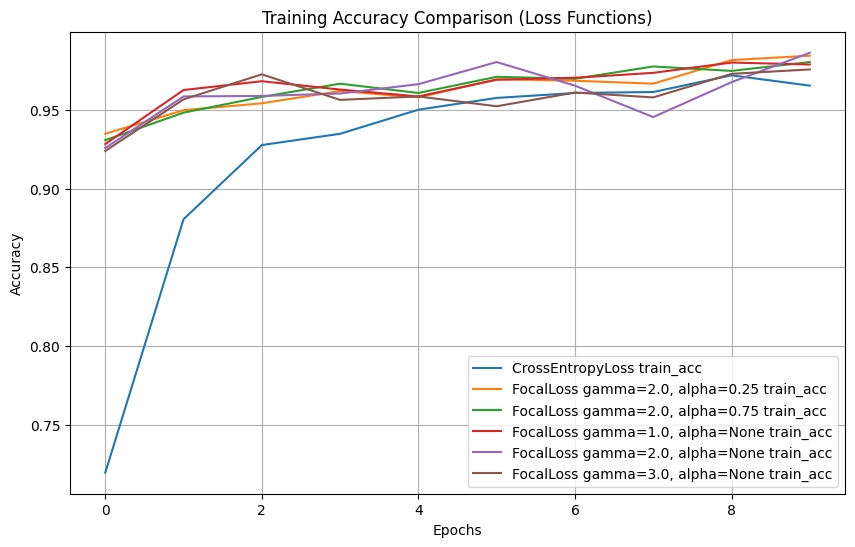

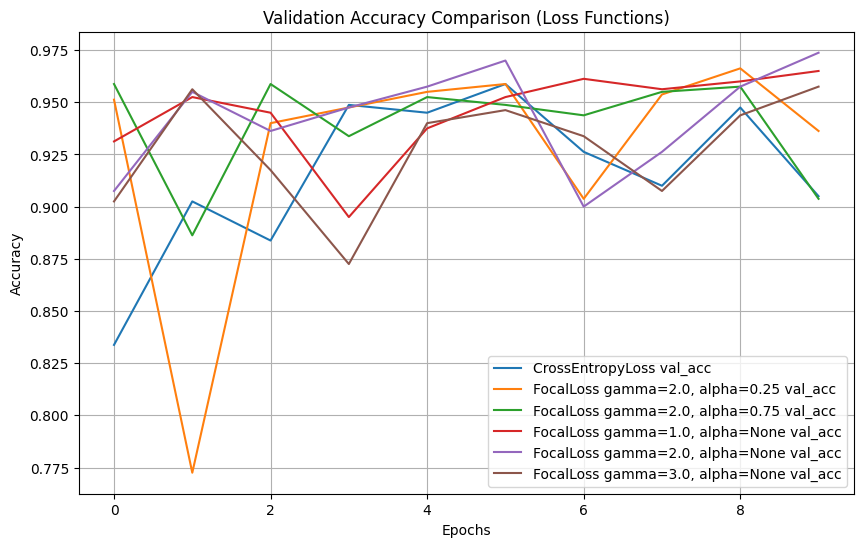

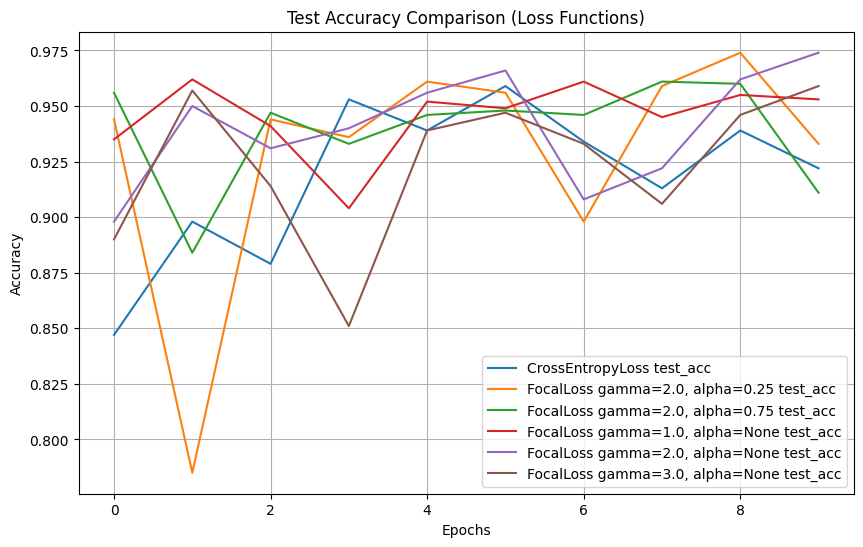

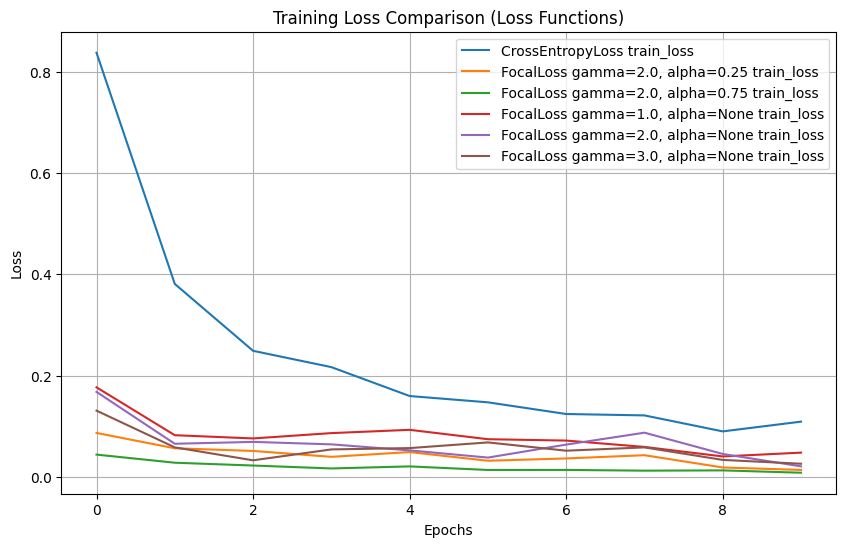

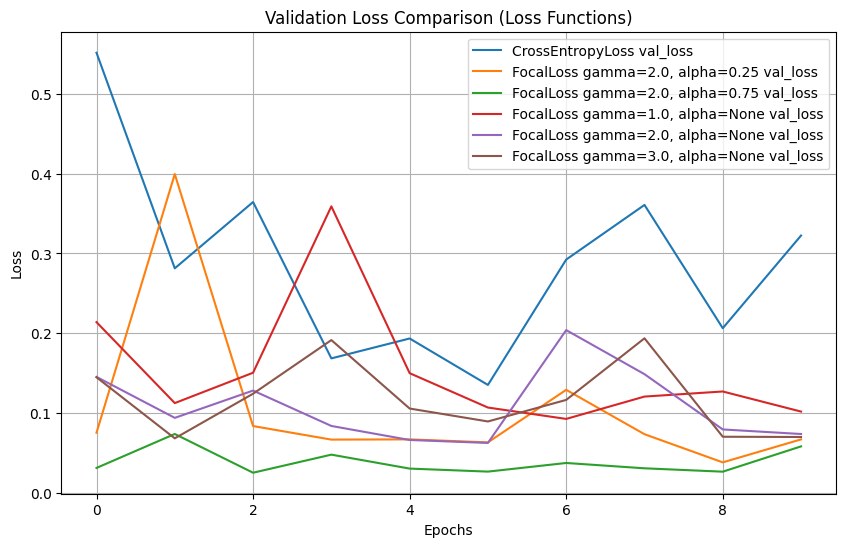

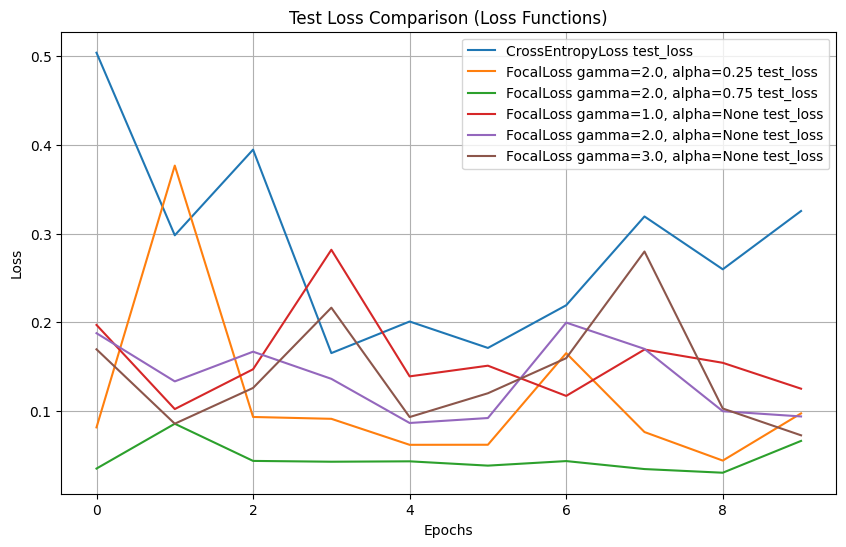

In [ ]:
# Fine-Tuning with Focal Loss with Inception V3

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, num_classes=8):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.num_classes = num_classes

    def forward(self, inputs, targets):
        # Apply softmax to the inputs to get probabilities
        probs = F.softmax(inputs, dim=1)

        # Convert targets to one-hot encoding
        targets = F.one_hot(targets, num_classes=self.num_classes).float()

        # Get the probabilities for the true class labels
        true_probs = torch.sum(probs * targets, dim=1)

        # Compute the Focal Loss
        focal_weight = (1 - true_probs) ** self.gamma

        # Reshape focal_weight to be compatible with targets
        focal_weight = focal_weight.view(-1, 1)

        if self.alpha is not None:
            # Alpha weighting for class imbalance
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            loss = -alpha_t * focal_weight * torch.log(true_probs).view(-1, 1)
        else:
            loss = -focal_weight * torch.log(true_probs).view(-1, 1)

        return loss.mean()

# Define a function to save the model checkpoint
def save_model_checkpoint(model, optimizer, epoch, file_path, history):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': history['train_loss'][-1],
        'val_loss': history['val_loss'][-1],
        'train_acc': history['train_acc'][-1],
        'val_acc': history['val_acc'][-1],
        'test_loss': history['test_loss'][-1],
        'test_acc': history['test_acc'][-1]
    }
    torch.save(checkpoint, file_path)
    print(f"Model checkpoint saved at {file_path}")

# Modify the function for optimizer training to correctly handle each optimizer
def train_with_loss_function(loss_fn, optimizer_class, optimizer_args, num_epochs, is_cross_entropy=False):
    print(f"Training with {loss_fn.__class__.__name__}...")

    if is_cross_entropy:
        return inception_history  # Using the pre-obtained loss and accuracy from CrossEntropyLoss training

    # Load checkpoint for other losses
    checkpoint = torch.load("inception_checkpoint.pth")
    inception_model.load_state_dict(checkpoint['model_state_dict'])

    # Define optimizer
    optimizer = optimizer_class(inception_model.parameters(), **optimizer_args)

    # Train the model and get history
    history = train_model(inception_model, loss_fn, optimizer, train_loader, val_loader, test_loader, num_epochs)
    return history

# Define Focal Loss parameteres
loss_fn_configs = [
    {"loss_fn": nn.CrossEntropyLoss(), "label": "CrossEntropyLoss", "is_cross_entropy": True},  # CrossEntropyLoss configuration
    {"loss_fn": FocalLoss(gamma=2.0, alpha=0.25), "label": "FocalLoss gamma=2.0, alpha=0.25", "is_cross_entropy": False},
    {"loss_fn": FocalLoss(gamma=2.0, alpha=0.75), "label": "FocalLoss gamma=2.0, alpha=0.75", "is_cross_entropy": False},
    {"loss_fn": FocalLoss(gamma=1.0, alpha=None), "label": "FocalLoss gamma=1.0, alpha=None", "is_cross_entropy": False},
    {"loss_fn": FocalLoss(gamma=2.0, alpha=None), "label": "FocalLoss gamma=2.0, alpha=None", "is_cross_entropy": False},
    {"loss_fn": FocalLoss(gamma=3.0, alpha=None), "label": "FocalLoss gamma=3.0, alpha=None", "is_cross_entropy": False}
]


optimizer_class = optim.Adam
optimizer_args = {"lr": 0.001}

# Train with different loss functions
loss_histories = {}
for config in loss_fn_configs:
    loss_histories[config['label']] = train_with_loss_function(
        loss_fn=config["loss_fn"],
        optimizer_class=optimizer_class,
        optimizer_args=optimizer_args,
        num_epochs=10,
        is_cross_entropy=config['is_cross_entropy']
    )

# Plot results
plot_comparison(loss_histories, 'train_acc', 'Accuracy', 'Training Accuracy Comparison (Loss Functions)')
plot_comparison(loss_histories, 'val_acc', 'Accuracy', 'Validation Accuracy Comparison (Loss Functions)')
plot_comparison(loss_histories, 'test_acc', 'Accuracy', 'Test Accuracy Comparison (Loss Functions)')
plot_comparison(loss_histories, 'train_loss', 'Loss', 'Training Loss Comparison (Loss Functions)')
plot_comparison(loss_histories, 'val_loss', 'Loss', 'Validation Loss Comparison (Loss Functions)')
plot_comparison(loss_histories, 'test_loss', 'Loss', 'Test Loss Comparison (Loss Functions)')